## Libraries

In [1]:
import os
import h5py
import cv2

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
%matplotlib inline

/Users/hyunwoogu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Loading

In [2]:
def load(dbname, dataset):
    '''
    dbname is the path to the database hdf file, dataset is the dataset name.
    returns a pandas dataframe and a dictionary with meta data for the dataset.
    '''
    attrs = None
    with h5py.File(dbname) as f:
        if dataset not in f.keys():
            raise ValueError('Can\'t find dataset. Available keys are: ' + str(f.keys()))
        try:
            df = pd.DataFrame(dict((k, f[dataset][k][:].ravel()) for k in f[dataset].keys()))
        except ValueError:
            raise RuntimeError('Not all fields have the same length:' +
                str(dict((k, f[dataset][k][:].ravel().shape) for k in f[dataset].keys())))
        if len(f[dataset].attrs.keys())>0:
            attrs = dict((k, f[dataset].attrs[k]) for k in  f[dataset].attrs.keys())
    return df, attrs

In [3]:
os.chdir('/Users/hyunwoogu/Dropbox/2018Autumn/GradThesis/EyeTracking_data/')

In [4]:
Data, attrs = load("etdb_v1.0.hdf5", "Face Discrim.")

## Exploratory Data Analysis

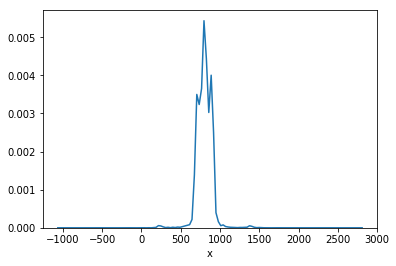

In [171]:
sns.distplot(Data['x'], hist=False)
plt.show()

## Data Processing

In [6]:
Data.columns.values

array(['SUBJECTINDEX', 'category', 'chain', 'condition', 'dataset_nr',
       'end', 'filenumber', 'fix', 'isref', 'phase', 'start', 'trial',
       'x', 'y'], dtype=object)

#### Counts and Duration

In [7]:
Data['counts'] = Data.groupby(['SUBJECTINDEX','trial']).cumcount()
Data.loc[:, 'Duration'] = Data.loc[:,'end'] - Data.loc[:,'start']

#### Right Censoring

In [8]:
Data.loc[(Data.counts==0) & (Data.end > 1450),['start', 'end', 'x', 'y', 'counts']].shape

(115, 5)

#### Face Feature Window

In [9]:
ChopSize = (80,60) ## pieces (x,y)
Data.loc[:, 'CumIndex'] = (Data.loc[:,'x']//ChopSize[0]) * ChopSize[0] + ((1200-Data.loc[:,'y'])//ChopSize[1])

#### Mean Duration by Face Features

In [10]:
def transparent_cmap(cmap, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.Reds)

In [203]:
for i in range(1, 33):
    FileNum = Data[Data['filenumber']==i]
    adr = '21/' + str(i) + '.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    if i==1 :
        res = img
    else :
        res = (res+img)/2

In [209]:
FileNames = os.listdir('21/')


In [213]:
w,h=Image.open( '21/'  + FileNames[0]).size
N=len(FileNames)


In [216]:
arr=numpy.zeros((h,w,3),numpy.float)


32

#### Averaging the faces

In [224]:
# Assuming all images are the same size, get dimensions of first image
w,h=Image.open('21/' + FileNames[0]).size
N=len(FileNames)

# Create a numpy array of floats to store the average (assume RGB images)
arr=np.zeros((h,w,3),np.float)

# Build up average pixel intensities, casting each image as an array of floats
for im in FileNames:
    imarr= np.array(Image.open('21/' + im),dtype=np.float)
    arr=arr+imarr/N

# Round values in array and cast as 8-bit integer
arr=np.array(np.round(arr),dtype=np.uint8)

# Generate, save and preview final image
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
out.show()

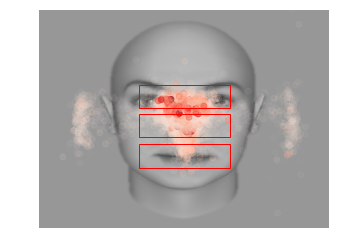

In [226]:
XwinSize = 500
YwinSize = 130

coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(Data.loc[(Data.counts==0),'x'], Data.loc[(Data.counts==0),'y'],\
            c=Data.loc[(Data.counts==0),'Duration'], cmap=mycmap)

rect1 = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)

plt.show()

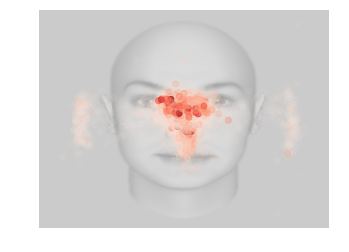

In [46]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(Data.loc[(Data.counts==0),'x'], Data.loc[(Data.counts==0),'y'],\
            c=Data.loc[(Data.counts==0),'Duration'], cmap=mycmap)
plt.show()


#### Optimal Window

In [230]:
def countFixations(startX, startY, XwinSize=500, YwinSize=130):
    res = Data.loc[(Data.counts==0) & 
                   (Data.x>=startX) & (Data.x<=startX+XwinSize) &
                   (Data.y>=startY) & (Data.y<=startY+YwinSize) ,'start'].shape[0]
    return(res)

In [243]:
def meanDurations(startX, startY, XwinSize=130, YwinSize=130):
    res = np.mean(Data.loc[(Data.counts==0) & 
                           (Data.x>=startX) & (Data.x<=startX+XwinSize) &
                            (Data.y>=startY) & (Data.y<=startY+YwinSize) ,'Duration'])
    return (res)

In [339]:
## Greedy Search

Xwinsize=150
Ywinsize=150

SegsX = np.arange(0, 1600-XwinSize, 20)
SegsY = np.arange(0, 1200-YwinSize, 20)

countRes = []
for i in SegsX:
    for j in SegsY:
        countRes.append((i,j,countFixations(i,j)))


IndexError: index 3875 is out of bounds for axis 0 with size 3869

In [ ]:
C = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]

[(0, 0, 0),
 (0, 20, 0),
 (0, 40, 0),
 (0, 60, 0),
 (0, 80, 0),
 (0, 100, 0),
 (0, 120, 0),
 (0, 140, 0),
 (0, 160, 0),
 (0, 180, 0),
 (0, 200, 0),
 (0, 220, 0),
 (0, 240, 0),
 (0, 260, 0),
 (0, 280, 0),
 (0, 300, 0),
 (0, 320, 2),
 (0, 340, 7),
 (0, 360, 18),
 (0, 380, 39),
 (0, 400, 69),
 (0, 420, 100),
 (0, 440, 129),
 (0, 460, 148),
 (0, 480, 168),
 (0, 500, 176),
 (0, 520, 176),
 (0, 540, 158),
 (0, 560, 158),
 (0, 580, 141),
 (0, 600, 142),
 (0, 620, 125),
 (0, 640, 105),
 (0, 660, 89),
 (0, 680, 73),
 (0, 700, 55),
 (0, 720, 36),
 (0, 740, 16),
 (0, 760, 7),
 (0, 780, 6),
 (0, 800, 3),
 (0, 820, 1),
 (0, 840, 1),
 (0, 860, 0),
 (0, 880, 0),
 (0, 900, 0),
 (0, 920, 0),
 (0, 940, 0),
 (0, 960, 0),
 (0, 980, 0),
 (0, 1000, 0),
 (0, 1020, 0),
 (0, 1040, 0),
 (20, 0, 0),
 (20, 20, 0),
 (20, 40, 0),
 (20, 60, 0),
 (20, 80, 0),
 (20, 100, 0),
 (20, 120, 0),
 (20, 140, 0),
 (20, 160, 0),
 (20, 180, 0),
 (20, 200, 0),
 (20, 220, 0),
 (20, 240, 0),
 (20, 260, 0),
 (20, 280, 0),
 (20, 300,

In [379]:
Xwinsize=30
Ywinsize=30

SegsX = np.arange(0, 1600-XwinSize, 10)
SegsY = np.arange(0, 1200-YwinSize, 10)

meanRes = []
for i in SegsX:
    for j in SegsY:
        meanRes.append((i,j,meanDurations(i,j)))
        
C = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]

In [341]:
A = np.array(countRes)[np.argsort(-np.array(countRes)[:,2]),:]
A

array([[ 540,  480, 8811],
       [ 560,  480, 8809],
       [ 520,  480, 8809],
       [ 580,  480, 8802],
       [ 600,  480, 8799],
       [ 500,  480, 8798],
       [ 480,  480, 8796],
       [ 540,  500, 8794],
       [ 520,  500, 8794],
       [ 560,  500, 8791],
       [ 580,  500, 8786],
       [ 600,  500, 8784],
       [ 500,  500, 8784],
       [ 480,  500, 8783],
       [ 620,  480, 8778],
       [ 460,  480, 8774],
       [ 620,  500, 8764],
       [ 460,  500, 8761],
       [ 640,  480, 8759],
       [ 640,  500, 8742],
       [ 440,  480, 8728],
       [ 440,  500, 8719],
       [ 660,  480, 8712],
       [ 660,  500, 8697],
       [ 420,  480, 8634],
       [ 420,  500, 8619],
       [ 680,  500, 8558],
       [ 680,  480, 8558],
       [ 400,  480, 8339],
       [ 400,  500, 8330],
       [ 540,  460, 8244],
       [ 520,  460, 8243],
       [ 560,  460, 8242],
       [ 500,  460, 8236],
       [ 580,  460, 8235],
       [ 480,  460, 8232],
       [ 600,  460, 8231],
 

In [143]:
A.shape

(3869, 3)

In [ ]:
coord2 = (720, 550)
coord3 = (720, 740)

In [321]:
tes1 = B[(680 <= B[:,0]) & (B[:,0] <= 760), :]

In [322]:
tes2 = B[(380 <= B[:,1]) & (B[:,1] <= 430), :]

In [272]:
tes[0, [0,1]]

array([680., 220.])

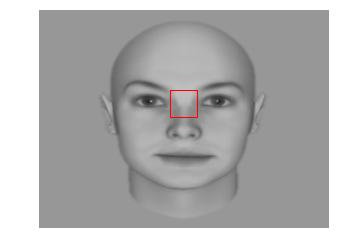

In [360]:
coord1 = (720, 440) ## x coord (from left), y coord (from top) 
XwinSize = 150
YwinSize = 150

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

Start = 200
End = 210

rect = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

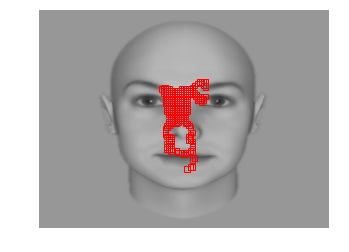

In [387]:
XwinSize = 30
YwinSize = 30

coord1 = (720, 440) ## x coord (from left), y coord (from top) 

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

Start = 300
End = 600

for i in range(Start, End+1) :
    rect = patches.Rectangle(C[i, [0,1]],XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [240]:
np.set_printoptions(threshold=np.inf)

In [320]:
B = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]

In [258]:
B[(680 <= B[:,0]) & (B[:,0] <= 760), :]

array([[ 680.        ,  220.        ,  277.        ],
       [ 680.        ,  200.        ,  277.        ],
       [ 700.        ,  160.        ,  277.        ],
       [ 700.        ,  180.        ,  277.        ],
       [ 700.        ,  220.        ,  277.        ],
       [ 680.        ,  180.        ,  277.        ],
       [ 680.        ,  160.        ,  277.        ],
       [ 760.        ,  240.        ,  277.        ],
       [ 700.        ,  200.        ,  277.        ],
       [ 760.        ,  660.        ,  263.9986631 ],
       [ 760.        ,  640.        ,  262.444333  ],
       [ 720.        ,  640.        ,  262.35931174],
       [ 740.        ,  660.        ,  262.34895833],
       [ 720.        ,  660.        ,  261.78353254],
       [ 740.        ,  640.        ,  260.01747573],
       [ 760.        ,  740.        ,  255.14084507],
       [ 720.        ,  740.        ,  254.50359712],
       [ 700.        ,  660.        ,  254.32826748],
       [ 740.        ,  740.

In [251]:
B[(380 <= B[:,1]) & (B[:,1] <= 430), :]

array([[ 860.        ,  420.        ,  260.85714286],
       [ 880.        ,  420.        ,  259.875     ],
       [ 900.        ,  420.        ,  254.69078947],
       [ 860.        ,  400.        ,  250.76148796],
       [ 880.        ,  400.        ,  250.59459459],
       [ 840.        ,  420.        ,  249.04914005],
       [ 780.        ,  420.        ,  241.74847375],
       [ 900.        ,  380.        ,  241.53846154],
       [ 900.        ,  400.        ,  241.22875817],
       [ 800.        ,  420.        ,  241.17168819],
       [ 820.        ,  420.        ,  240.96253071],
       [ 840.        ,  400.        ,  239.34876543],
       [ 680.        ,  420.        ,  238.26142768],
       [ 700.        ,  420.        ,  237.96229857],
       [ 880.        ,  380.        ,  237.78378378],
       [ 660.        ,  420.        ,  236.65277287],
       [ 860.        ,  380.        ,  236.41011236],
       [ 760.        ,  420.        ,  235.83646209],
       [ 740.        ,  420.

In [245]:
B = np.array(meanRes)[np.argsort(-np.array(meanRes)[:,2]),:]
print(B)

[[ 940.          780.          346.        ]
 [ 920.          800.          346.        ]
 [ 900.          800.          346.        ]
 [ 940.          800.          346.        ]
 [ 800.          260.          277.        ]
 [ 780.          240.          277.        ]
 [ 680.          220.          277.        ]
 [ 680.          200.          277.        ]
 [ 700.          160.          277.        ]
 [ 700.          180.          277.        ]
 [ 700.          220.          277.        ]
 [ 780.          260.          277.        ]
 [ 680.          180.          277.        ]
 [ 680.          160.          277.        ]
 [ 760.          240.          277.        ]
 [ 700.          200.          277.        ]
 [ 800.          240.          277.        ]
 [ 860.          800.          267.75      ]
 [ 960.          340.          267.33333333]
 [ 800.          660.          266.96407186]
 [ 780.          660.          264.78654971]
 [ 760.          660.          263.9986631 ]
 [ 780.   

In [144]:
mycmapR = transparent_cmap(plt.cm.Reds)
mycmapB = transparent_cmap(plt.cm.Blues)

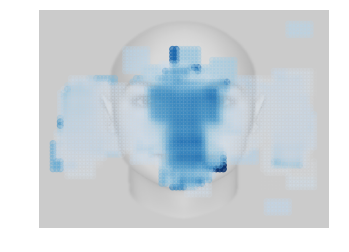

In [154]:
fig, ax = plt.subplots()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img, alpha=.5)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax.scatter(B[:,0]+75, B[:,1]+75, c=B[:,2], cmap=mycmapB)
plt.show()

#### Fixation proportion as a function of time

In [12]:
def FixationProp(t):
    return(sum((Data.loc[:,'start'] <= t) & (Data.loc[:,'end'] >= t)))

In [ ]:
def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'end'] >= t)))

In [86]:
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=390) & (Data.y<=540), 'Duration'].shape # original eye

(1183,)

In [75]:
Data.loc[(Data.x>=520) & (Data.x<=670) & (Data.y>=660) & (Data.y<=810) ,'start'].shape # reverse eye

(87,)

In [76]:
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=480) & (Data.y<=630) ,'start'].shape # original concen

(24028,)

In [77]:
Data.loc[(Data.x>=600) & (Data.x<=750) & (Data.y>=570) & (Data.y<=720) ,'start'].shape # reverse concen

(2946,)

In [78]:
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=720) & (Data.y<=870) ,'start'].shape # original mouth

(5891,)

In [79]:
Data.loc[(Data.x>=720) & (Data.x<=870) & (Data.y>=330) & (Data.y<=480) ,'start'].shape # reverse mouth

(748,)

In [168]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=410) & (Data.y<=410+150) ,'Duration'].shape

(6324,)

In [169]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=570) & (Data.y<=570+150) ,'Duration'].shape

(3518,)

In [170]:
Data.loc[(Data.counts==0) & 
                           (Data.x>=550) & (Data.x<=550+500) &
                            (Data.y>=740) & (Data.y<=740+150) ,'Duration'].shape

(165,)

In [163]:
coord = (520, 390) ## x coord (from left), y coord (from top) 
coord = (720, 720)
(720, 550)

coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
#coord4 = (900, 410)

def FixationProp1(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=410) & (Data.y<=560) ,'end'] >= t)))

def FixationProp2(t):
    return(sum((Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'start'] <= t) & 
               (Data.loc[(Data.counts==0) & (Data.x>=550) & (Data.x<=1050) & (Data.y>=740) & (Data.y<=890) ,'end'] >= t)))

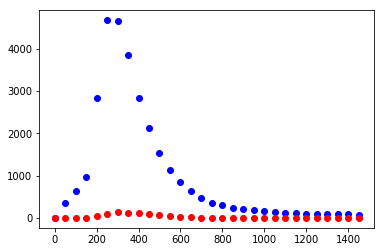

In [164]:
timeSegs = np.arange(0, 1500, 50)
props1 = [FixationProp1(x) for x in timeSegs]
props2 = [FixationProp2(x) for x in timeSegs]

plt.plot(timeSegs, props1, 'bo')
plt.plot(timeSegs, props2, 'ro')

plt.show()

**Maxtrix Method**

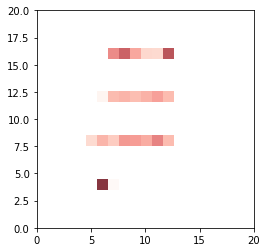

In [179]:
Data_index = Data.loc[(Data.counts==0)]
Data_index = Data_index.groupby(['CumIndex']).mean()
Data_index.index.name = 'CumIndex'
Data_index.reset_index(inplace=True)
Data_index = Data_index.loc[(Data_index.CumIndex >= 0) & (Data_index.CumIndex < 20*20),\
                            ['CumIndex', 'Duration']]
Data_index = Data_index.set_index('CumIndex').reindex(range(0,20*20)).fillna(0).reset_index()
Data_index = Data_index.Duration.values.reshape(20,20)

plt.imshow(Data_index, cmap='Reds', interpolation='nearest')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

In [ ]:
df.groupby(['cluster']).mean()

In [68]:
Order = Data[Data['filenumber']==Num]

## Image Handling

In [10]:
def transparent_cmap(cmap, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

mycmap = transparent_cmap(plt.cm.Reds)

#### Gaze map by different faces

pictures used : (21, 5, 1, 17, 29, 13) based on the frequency.

Pic|Freq
-|-
21|    10660
5|     10289
1|     10215
17|    10146
29|     9292
13|     9065

KeyboardInterrupt: 

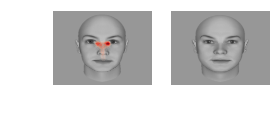

In [13]:
fig = plt.figure()

for i, Num in enumerate((21, 5, 1, 17, 29, 13)):
    
    FileNum = Data[Data['filenumber']==Num]
    adr = '21/' + str(Num) + '.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "23" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(FileNum['x'], FileNum['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

#### Salience map by fixation area

In [378]:
meanDurations(coord1[0], )

TypeError: meanDurations() missing 1 required positional argument: 'startY'

In [ ]:
coord1

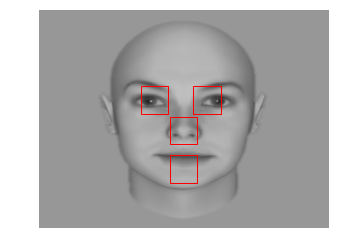

In [377]:
coord1 = (560, 420) ## x coord (from left), y coord (from top) 
coord2 = (850, 420)
coord3 = (720, 590)
coord4 = (720, 800)

XwinSize = 150
YwinSize = 150

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
rect4 = patches.Rectangle(coord4,XwinSize,YwinSize,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect4)

plt.show()

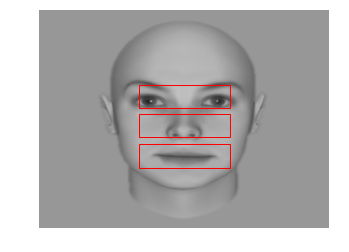

In [225]:
coord1 = (550, 410) ## x coord (from left), y coord (from top) 
coord2 = (550, 570)
coord3 = (550, 740)
#coord4 = (900, 410)

fig, ax = plt.subplots(1)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

rect1 = patches.Rectangle(coord1,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
rect2 = patches.Rectangle(coord2,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
rect3 = patches.Rectangle(coord3,500,130,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect3)
#rect4 = patches.Rectangle(coord4,150,150,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect4)

plt.show()

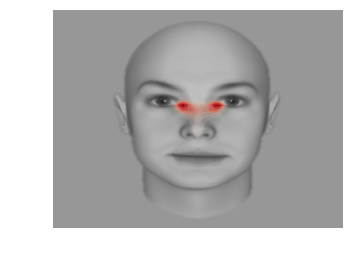

In [14]:
fig = plt.figure()

Num = 1
FileNum = Data[Data['filenumber']==Num]
adr = '21/' + str(Num) + '.png'
img = cv2.imread(adr, 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.axis('off')

ax = sns.kdeplot(FileNum['x'], FileNum['y'], shade = True, cmap = mycmap)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)

plt.show()

#### Salience map by fixation order

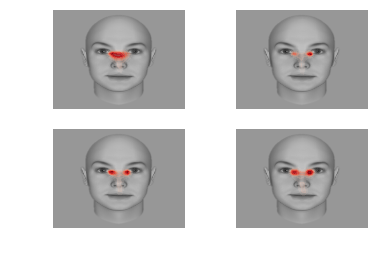

In [125]:
fig = plt.figure()

for i, Order in enumerate((1, 3, 5, 7)):
    
    GazeOrder = Data[Data['counts']==Order]
    adr = '21/1.png'
    img = cv2.imread(adr, 1)
    img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)
    
    fig_num = "22" + str(i+1)
    fig.add_subplot(int(fig_num))

    plt.imshow(img)
    plt.xlim(0, 1600)
    plt.ylim(1200, 0)
    plt.axis('off')

    ax = sns.kdeplot(GazeOrder['x'], GazeOrder['y'], shade = True, cmap = mycmap)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)

plt.show()

## Survival Analysis

## Prediction

## Eye-contact Simulation